# Breaking workflows 
Applying MS false peptide match logic to my workflows to show that, despite the fact that a high number of citations is the best predictor of highly rated workflow, it does not contain any co-usage information and is therefore not a good metric. 

In [17]:
import json
import sys
import os
import matplotlib.pyplot as plt 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import json
import wfqc.network as nw
from scipy.stats import ttest_rel
import numpy as np 
from wfqc.metrics import connectivity, citations 



The aim is to infer functional relationships based on citation patterns. The underlying assumption is that tools used together in a workflow are likely to be cited together in research papers. Additionally, tools with similar functions may also frequently appear together in citations. The most straightforward metric for evaluating a functional workflow is by identifying which tool has the most citations.

I plan to create a reverse dataset because I believe that examining the number of co-citations of tools provides more insight into their co-usage. The correlation between citation counts and high ratings may be influenced by confounding factors, such as the frequent use of highly cited tools. However, this does not necessarily indicate that these tools are often used together.

To test this, I will compile a list of the top 200 most cited tools and then disrupt well-performing workflows by randomly replacing one tool with one from this top 200 list. This approach aims to demonstrate that a good metric should meet certain criteria: 

1. If all connections (edges) represent viable, functional, and actually used tool combinations, the metric should yield a high score.
2. If an edge is replaced with a better one, the metric score should increase, and vice versa.

I hope to show that the connectivity between tools in a graph more accurately reflects the true functional relationships between tools, although the rated dataset correlates more just to the number of citations a tool has.

In [18]:
with open('../out_202407041439/edgestopic_0121.json', 'r') as f:
    citation_data = json.load(f)

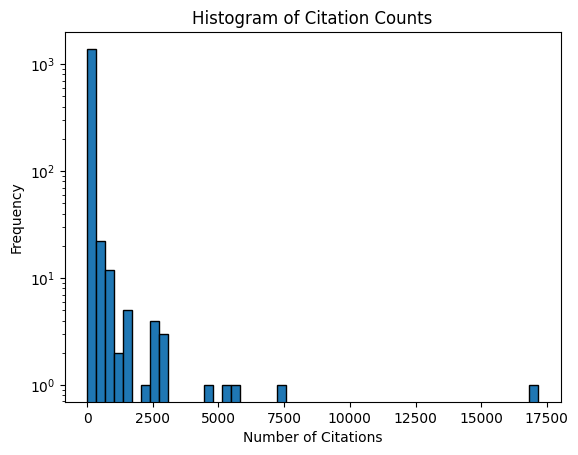

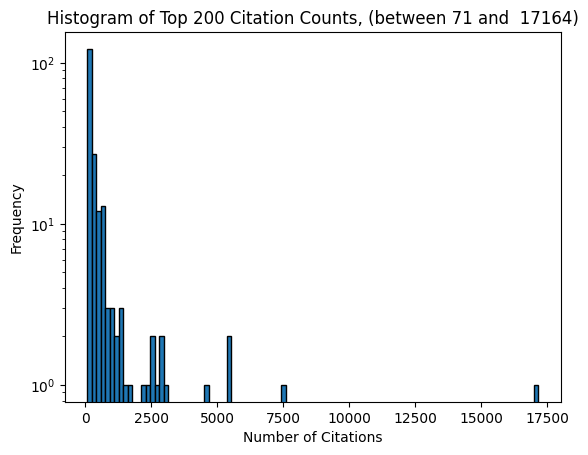

Loading saved data.


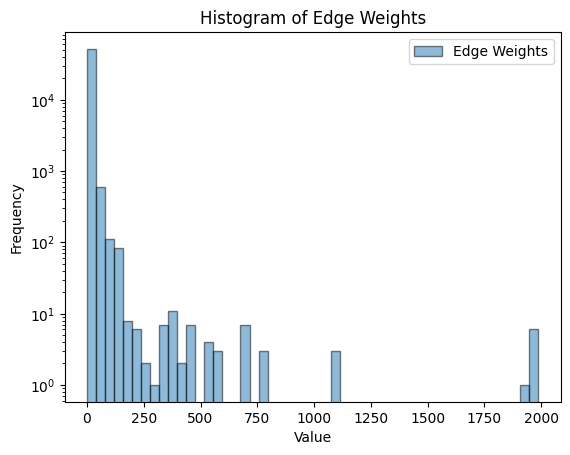

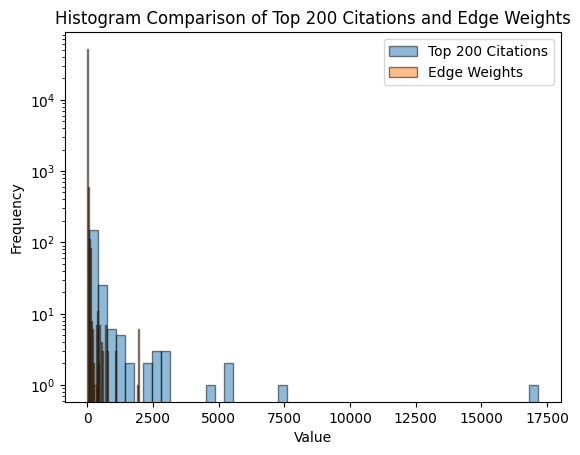

In [19]:
# citation counts for each tool
citation_counts = {tool['pmid']: tool['nrCitations'] for tool in citation_data['tools']}
citation_values = list(citation_counts.values())

# all citation counts
plt.hist(citation_values, bins=50, edgecolor='black')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Citation Counts')
plt.show()

# Sorting citations in descending order to get the top 200 most cited tools
sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top_200_citation_counts = list(sorted_citation_counts.values())[0:200]

# Plotting histogram of the top 200 citation counts
plt.hist(top_200_citation_counts, bins=100, edgecolor='black')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title(f'Histogram of Top 200 Citation Counts, (between {min(top_200_citation_counts)} and  {max(top_200_citation_counts)})')
plt.show()

# Loading a graph to analyse the distribution of edge weights
graph = nw.create_citation_network(inpath='../out_202407041439')
edge_weights = graph.es['weight']

# Plot hedge weights 
plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights')
plt.legend(loc='upper right')
plt.show()


# Plot histograms for top 200 citation counts and edge weights to ensure they are smaller than the citation counts 
plt.hist(top_200_citation_counts, bins=50, alpha=0.5, label='Top 200 Citations', edgecolor='black')
plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram Comparison of Top 200 Citations and Edge Weights')
plt.legend(loc='upper right')
plt.show()


### breaking workflows


In [20]:
with open('../out_202407041439/train_rated.json', 'r') as f:
    rated_workflows = json.load(f)

In [21]:
print(len(rated_workflows))

250


In [22]:
highly_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] >= 2] # this means that at least one of them gave it a two or higher

In [23]:
print(len(highly_rated_workflows))


50


In [24]:
def break_workflow(workflow: list, replacing_tools: list) -> list:
    """
    Takes a workflow and randomly exchanges one of its tools with one from an given set

    """
    tools = set()

    tools = {pmid for tup in workflow for pmid in tup if pmid is not None} # collect what tools are in the workflow, ignoring Nones
    tool_to_replace = np.random.choice(list(tools))
    replacing_tool = str(np.random.choice(replacing_tools)) ## do I want too also collect the comparison of their citation counts? 

    broken_workflow = []
    for source, target in workflow:
        if source == tool_to_replace:
            broken_workflow.append( (replacing_tool, target) )
        elif target == tool_to_replace:
            broken_workflow.append( (source, replacing_tool) )
        else:
            broken_workflow.append( (source, target) )
    return broken_workflow





In [25]:
def convert_to_tuples(list_of_lists):
    """
    Converts a list of lists into a list of tuples.

    :param list_of_lists: List of lists to be converted.
    :return: List of tuples.
    """
    return [tuple(inner_list) for inner_list in list_of_lists]


In [26]:
sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top200_tools = list(sorted_citation_counts.keys())[0:50] # changed to top 100 # TODO: check that these have on avg higher 

all_scores = []
for workflow in highly_rated_workflows:
    workflow = convert_to_tuples(workflow)
    if not workflow:
        continue
    # Original scores:
    og_connectivity_score = connectivity(graph, workflow)
    og_cite_score = citations(citation_data, workflow)

    broken_workflow = break_workflow(workflow, top200_tools)

    # Scores after breaking the workflow
    broken_connectivity_score = connectivity(graph, broken_workflow)
    broken_cite_score = citations(citation_data, broken_workflow)

    all_scores.append({
        'original connectivity score': og_connectivity_score,
        'original citation score': og_cite_score,
        'broken connectivity score': broken_connectivity_score,
        'broken citation score': broken_cite_score
    })


In [27]:
# do testing that the breaking is functional and correct !! TODO

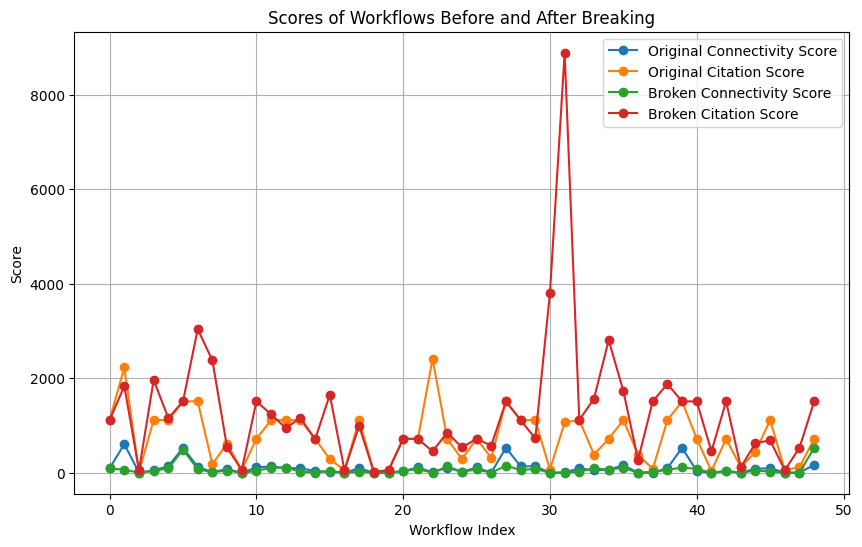

In [28]:
original_connectivity_scores = [score['original connectivity score'] for score in all_scores]
original_citation_scores = [score['original citation score'] for score in all_scores]
broken_connectivity_scores = [score['broken connectivity score'] for score in all_scores]
broken_citation_scores = [score['broken citation score'] for score in all_scores]

plt.figure(figsize=(10, 6))

plt.plot(original_connectivity_scores, label='Original Connectivity Score', marker='o')
plt.plot(original_citation_scores, label='Original Citation Score', marker='o')
plt.plot(broken_connectivity_scores, label='Broken Connectivity Score', marker='o')
plt.plot(broken_citation_scores, label='Broken Citation Score', marker='o')

plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.title('Scores of Workflows Before and After Breaking')
plt.legend()
plt.grid(True)
plt.show()

In [29]:

t_stat, p_value = ttest_rel(original_connectivity_scores, broken_connectivity_scores)
print(t_stat, p_value )

alpha = 0.05  
if p_value < alpha and np.mean(original_connectivity_scores) > np.mean(broken_connectivity_scores):
    print("It is probable that the original connectivity scores are significantly higher than the broken connectivity scores.")
else:
    print("There is no significant evidence that the original connectivity scores are higher than the broken connectivity scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = ttest_rel(original_citation_scores, broken_citation_scores)

alpha = 0.05 
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the broken citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the broken citation scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

2.0193608441858353 0.04905263839120745
It is probable that the original connectivity scores are significantly higher than the broken connectivity scores.
t-statistic: 2.0193608441858353, p-value: 0.04905263839120745
There is no significant evidence that the original citation scores are higher than the broken citation scores.
t-statistic: -2.6287522581479834, p-value: 0.011477231181178197


In [30]:
from wfqc.workflow import generate_random_workflow

# I will now create randomm workflows with the same strructure as the original ones, using only the top 200 tools

higly_ranked_workflow_scores = []
random_workflow_scores = []
citations_higly_ranked_workflow_scores = []
citations_random_workflow_scores = []

for workflow in highly_rated_workflows:
    workflow = convert_to_tuples(workflow)
    if not workflow:
        continue
    
    random_workflow = generate_random_workflow(top200_tools, workflow)


    higly_ranked_workflow_scores.append( connectivity(graph, workflow) )
    random_workflow_scores.append( connectivity(graph, random_workflow) )

    citations_higly_ranked_workflow_scores.append( citations(citation_data, workflow) )
    citations_random_workflow_scores.append( citations(citation_data, random_workflow) )


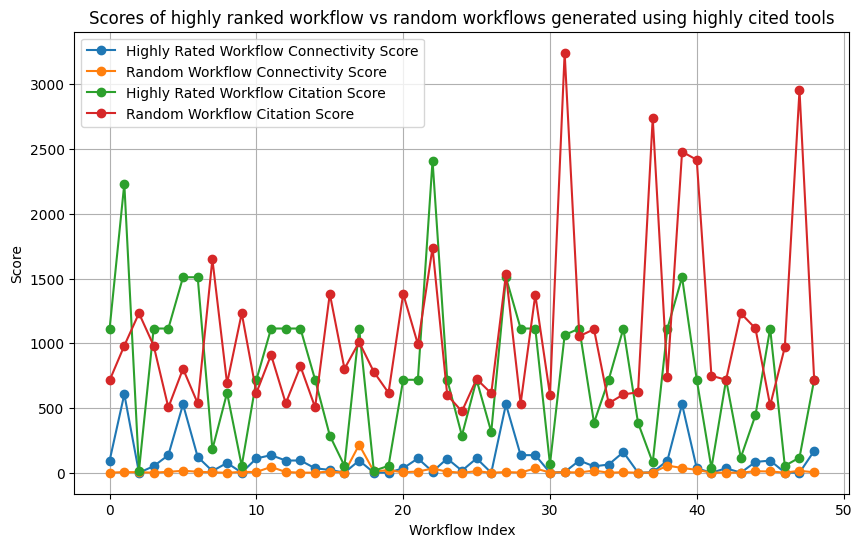

In [32]:

plt.figure(figsize=(10, 6))

plt.plot(higly_ranked_workflow_scores, label='Highly Rated Workflow Connectivity Score', marker='o')
plt.plot(random_workflow_scores, label='Random Workflow Connectivity Score', marker='o')
plt.plot(citations_higly_ranked_workflow_scores, label='Highly Rated Workflow Citation Score', marker='o')
plt.plot(citations_random_workflow_scores, label='Random Workflow Citation Score', marker='o')

plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.title('Scores of highly ranked workflow vs random workflows generated using highly cited tools')
plt.legend()
plt.grid(True)
plt.show()

In [34]:

t_stat, p_value = ttest_rel(higly_ranked_workflow_scores, random_workflow_scores)
print(t_stat, p_value )

alpha = 0.05  
if p_value < alpha and np.mean(original_connectivity_scores) > np.mean(broken_connectivity_scores):
    print("It is probable that the original connectivity scores are significantly higher than the random workflow connectivity scores.")
else:
    print("There is no significant evidence that the original connectivity scores are higher than the random workflow connectivity scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = ttest_rel(citations_higly_ranked_workflow_scores, citations_random_workflow_scores)

alpha = 0.05 
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the random workflow citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the random workflow citation scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

4.066817672756396 0.00017634693936939455
It is probable that the original connectivity scores are significantly higher than the random workflow connectivity scores.
t-statistic: 4.066817672756396, p-value: 0.00017634693936939455
There is no significant evidence that the original citation scores are higher than the random workflow citation scores.
t-statistic: -2.513868304469538, p-value: 0.015349526058490204
